In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../src')

from pathlib import Path
import pandas as pd
from zipfile import ZipFile
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from models import run_model_dep_classification, append_df_metrics, append_df_importances, create_df_importances
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from models import classification_metrics
import copy
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import pydot
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from models import plot_roc_curve, plot_cm
from models import prune_duplicate_leaves

PNS_DATA = Path('../data/processed/PNS_2019/all.zip').resolve()
zip_pns = ZipFile(PNS_DATA)
df = pd.read_csv(zip_pns.open(zip_pns.namelist()[0]), sep=",", low_memory=False)

PATH_GEN_DATA = Path('generated_data/pns_data_models').resolve()

def process_df(df_i, remove_na=True):
    df_i = copy.deepcopy(df_i)
    if remove_na:
        df_i = df_i.dropna()
    return df_i.drop(['r_norte', 'r_nordeste', 'r_sudeste', 'r_sul', 'r_centro_oeste'], axis=1)

# Criação das variaveis de interesse

#### Label

In [2]:
# Target
df['depression'] = np.where(df['phq9_total'].isna(), np.nan, np.where(df['phq9_total'] >= 10, 1, 0))
df = df.dropna(subset=['depression'])
df['depression'].value_counts()

#### Features derivadas

In [3]:
# Alimentos in natura ou minimamente processado
innatura = ['P00601','P00602', 'P00603', 'P00604', 'P00605', 'P00607', 'P00608', 'P00609', 'P00610', 'P00611', 'P00612', 'P00613']
df_innatura = df[innatura]
df_innatura['qst_innatura'] = (df_innatura == 1.0).sum(axis=1)
# Alimentos ultraprocessados
ultraprocessados = ['P00614', 'P00615', 'P00616', 'P00617', 'P00618', 'P00619', 'P00620', 'P00621', 'P00622', 'P00623']
df_upf = df[ultraprocessados]
df_upf['qst_upf'] = (df_upf == 1.0).sum(axis=1)

# A literatura não usa a porcentagem de ultraprocessados do prato como análise. O artigo 'Food consumption and depression among Brazilian adults: results from the Brazilian National Health Survey, 2013'
# Usa como base o número de perguntas respondidas 'Sim' nos alimentos ultraprocessados das ultimas 24hrs
df['per_innatura'] = df_innatura['qst_innatura'] / (df_innatura['qst_innatura'] + df_upf['qst_upf']) * 100
df['per_upf'] = df_upf['qst_upf'] / (df_innatura['qst_innatura'] + df_upf['qst_upf']) * 100
df['qst_upf'] = df_upf['qst_upf'] # Baseado no artigo

def classify_upf(row):
    value = row['qst_upf']

    if  0 <= value < 2:
        return 1
    elif value < 4:
        return 2
    elif value < 6:
        return 3
    elif value < 8:
        return 4
    elif value <= 10:
        return 5

    return np.nan # questionario não respondido

df['upf_severity'] = df.apply(classify_upf, axis=1)


def count_imc(row):
    height = row['altura']
    weight = row['peso']

    imc = weight/np.square(height/100)   # Peso está em kg e altura em cm, no calculo do imc é kg/m^2
    return imc

df['imc'] = df.apply(count_imc, axis=1)


def classify_imc(row):
    value = row['imc']

    if  0 <= value < 18.5:
        return 1  # Baixo peso
    elif value < 24.9:
        return 2 # Eutrofia/peso adequado
    elif value < 29.9:
        return 3   # Sobrepeso
    elif value >= 30:
        return 4  # Obesidade

    return np.nan # questionario não respondido

df['class_imc'] = df.apply(classify_imc, axis=1)


def classify_idade(row):
    value = row['idade']
    if  18 <= value <= 29:
        return 1
    elif value <= 39:
        return 2
    elif value <= 49:
        return 3
    elif value <= 59:
        return 4

    return np.nan

df['class_idade'] = df.apply(classify_idade, axis=1)


# Essa variável foi criada a partir de um índice utilizado pela OMS. Na literatura, usam a pergunta 'P034' relacionada à prática de exercícios físicos nos ultimos 3 meses
df_activity = pd.DataFrame()
df_activity['minutes_per_week'] = df['P03702'] * df['P035']

vigorous_activities = [3.0, 4.0, 5.0, 6.0, 12.0, 13.0, 15.0]
moderated_activities = [1.0, 2.0, 7.0, 8.0, 9.0, 10.0, 11.0, 14.0, 16.0, 17.0]
df_activity['time_vigorous'] = df_activity['minutes_per_week'].loc[df['P036'].isin(vigorous_activities)]
df_activity['time_moderated'] = df_activity['minutes_per_week'].loc[df['P036'].isin(moderated_activities)]

df_activity['activity_class'] = 0
df_activity.loc[df_activity['minutes_per_week'].isna(), 'activity_class'] = np.nan
df_activity.loc[(df_activity['time_vigorous'] >= 75) | (df_activity['time_moderated'] >= 150), 'activity_class'] = 1

df['activity_class'] = df_activity['activity_class']
df['exerc_fisico'] = np.where(df['P034'].isin([1.0]), 1, np.where(df['P034'] == 2.0, 0, np.nan))
df['tabagismo'] = np.where(df['P050'].isin([1.0, 2.0]), 1, np.where(df['P050'] == 3.0, 0, np.nan))

# Na literatura eles usam outra variável para analisar o consumo alcoolico
# df['cons_alcool'] = np.where(df['P02801'] >= 1, 1, 0)
# df['cons_alcool'] = np.where(df['P02801'].isna(), np.nan, df['cons_alcool'])

# Olhar artigo 'Food consumption and depression among Brazilian adults: results from the Brazilian National Health Survey, 2013'
df['cons_alcool'] = np.where(df['P027'].isin([2.0, 3.0]), 1, np.where(df['P027'] == 1.0, 0, np.nan))

df = df[df['P005'] != 1.0] #Retirando as grávidas da análise

df['obesidade'] = np.where(df['class_imc'].isna(), np.nan, np.where(df['class_imc'] >= 4, 1, 0))

# Limitação da análise por idades que se adequam ao PHQ9 baseado no artigo 'Food consumption and depression among Brazilian adults: results from the Brazilian National Health Survey, 2013'
df = df[(df['idade'] >= 18) & (df['idade'] <= 59)]


regiao_mapping = {
    'r_norte': [11, 12, 13, 14, 15, 16, 17],
    'r_nordeste': [21, 22, 23, 24, 25, 26, 27, 28, 29],
    'r_sudeste': [31, 32, 33, 35],
    'r_sul': [41, 42, 43],
    'r_centro_oeste': [50, 51, 52, 53]
}

for regiao, estados in regiao_mapping.items():
    df[regiao] = df['uf'].apply(lambda x: int(x in estados))


df['class_renda'] = np.where(df['renda_pc'].isin([4.0, 5.0, 6.0, 7.0]), 1, np.where(df['renda_pc'].isin([1.0, 2.0, 3.0]), 0, np.nan))

In [30]:
df['depression'].value_counts()

depression
0.0    57816
1.0     6848
Name: count, dtype: int64

# Análise de dados faltantes

#### População total

In [5]:
print('Faltantes em Q092 - pergunta do diagnóstico de depressão: ', df['Q092'].isna().sum(), 'Perc:',  round(df['Q092'].isna().sum()/len(df['Q092'])*100, 3))
print('Faltantes em PHQ9_total - classificação de grau de depressão: ', df['phq9_total'].isna().sum(), 'Perc:',  round(df['phq9_total'].isna().sum()/len(df['phq9_total'])*100, 3))
print('Faltantes em vive_conjugue - classificação do estado civil: ', df['vive_conjugue'].isna().sum(), 'Perc:',  round(df['vive_conjugue'].isna().sum()/len(df['vive_conjugue'])*100, 3))
print('Faltantes em class_idade - classificação de idade: ', df['class_idade'].isna().sum(), 'Perc:',  round(df['class_idade'].isna().sum()/len(df['class_idade'])*100, 3))
print('Faltantes em cor - cor ou raça autodeclaradas: ', df['cor'].isna().sum(), 'Perc:',  round(df['cor'].isna().sum()/len(df['cor'])*100, 3))

print('Faltantes em UPF_severity - classificação de consumo de ultraprocessados: ', df['upf_severity'].isna().sum(), 'Perc:',  round(df['upf_severity'].isna().sum()/len(df['upf_severity'])*100, 3))
print('Faltantes em exerc_fisico - classificação de atividade física: ', df['exerc_fisico'].isna().sum(), 'Perc:',  round(df['exerc_fisico'].isna().sum()/len(df['exerc_fisico'])*100, 3))
print('Faltantes em tabagist - classificação de tabagismo: ', df['tabagismo'].isna().sum(), 'Perc:',  round(df['tabagismo'].isna().sum()/len(df['tabagismo'])*100, 3))
print('Faltantes em cons_alcool - classificação do consumo de álcool: ', df['cons_alcool'].isna().sum(), 'Perc:',  round(df['cons_alcool'].isna().sum()/len(df['cons_alcool'])*100, 3))

print('Faltantes em Q120 - pergunta do diagnóstico de cancer: ', df['Q120'].isna().sum(), 'Perc:',  round(df['Q120'].isna().sum()/len(df['Q120'])*100, 3))
print('Faltantes em Q00201 - diagnotisco pressão alta: ', df['Q00201'].isna().sum(), 'Perc:',  round(df['Q00201'].isna().sum()/len(df['Q00201'])*100, 3))
print('Faltantes em Q03001 - diagnostico diabetes: ', df['Q03001'].isna().sum(), 'Perc:',  round(df['Q03001'].isna().sum()/len(df['Q03001'])*100, 3))
print('Faltantes em Q06306 - diagnostico cardiovascular : ', df['Q06306'].isna().sum(), 'Perc:',  round(df['Q06306'].isna().sum()/len(df['Q06306'])*100, 3))
print('Faltantes em Q060 - diagnostico colesterol alto: ', df['Q060'].isna().sum(), 'Perc:',  round(df['Q060'].isna().sum()/len(df['Q060'])*100, 3))
print('Faltantes em Q068 - diagnostico de AVC: ', df['Q068'].isna().sum(), 'Perc:',  round(df['Q068'].isna().sum()/len(df['Q068'])*100, 3))
print('Faltantes em Q079 - diagnostico de artrite: ', df['Q079'].isna().sum(), 'Perc:',  round(df['Q079'].isna().sum()/len(df['Q079'])*100, 3))
print('Faltantes em class_imc - classificação de imc: ', df['class_imc'].isna().sum(), 'Perc:',  round(df['class_imc'].isna().sum()/len(df['class_imc'])*100, 3))

## População considerada depressiva (PHQ9>=10)

In [6]:
new_df = df[df['phq9_total'] >= 10].copy()
print('Faltantes em Q092 - pergunta do diagnóstico de depressão: ', new_df['Q092'].isna().sum(), 'Perc:',  round(new_df['Q092'].isna().sum()/len(new_df['Q092'])*100, 3))
print('Faltantes em vive_conjugue - classificação do estado civil: ', new_df['vive_conjugue'].isna().sum(), 'Perc:',  round(new_df['vive_conjugue'].isna().sum()/len(new_df['vive_conjugue'])*100, 3))
print('Faltantes em class_idade - classificação de idade: ', new_df['class_idade'].isna().sum(), 'Perc:',  round(new_df['class_idade'].isna().sum()/len(new_df['class_idade'])*100, 3))
print('Faltantes em cor - cor ou raça autodeclaradas: ', new_df['cor'].isna().sum(), 'Perc:',  round(new_df['cor'].isna().sum()/len(new_df['cor'])*100, 3))

print('Faltantes em UPF_severity - classificação de consumo de ultraprocessados: ', new_df['upf_severity'].isna().sum(), 'Perc:',  round(new_df['upf_severity'].isna().sum()/len(new_df['upf_severity'])*100, 3))
print('Faltantes em activity_class - classificação de atividade física: ', new_df['activity_class'].isna().sum(), 'Perc:',  round(new_df['activity_class'].isna().sum()/len(new_df['activity_class'])*100, 3))
print('Faltantes em tabagist - classificação de tabagismo: ', new_df['tabagismo'].isna().sum(), 'Perc:',  round(new_df['tabagismo'].isna().sum()/len(new_df['tabagismo'])*100, 3))
print('Faltantes em cons_alcool - clasificação do consumo de álcool: ', new_df['cons_alcool'].isna().sum(), 'Perc:',  round(new_df['cons_alcool'].isna().sum()/len(new_df['cons_alcool'])*100, 3))

print('Faltantes em Q120 - pergunta do diagnóstico de cancer: ', new_df['Q120'].isna().sum(), 'Perc:',  round(new_df['Q120'].isna().sum()/len(new_df['Q120'])*100, 3))
print('Faltantes em Q00201 - diagnotisco pressão alta: ', new_df['Q00201'].isna().sum(), 'Perc:',  round(new_df['Q00201'].isna().sum()/len(new_df['Q00201'])*100, 3))
print('Faltantes em Q03001 - diagnostico diabetes: ', new_df['Q03001'].isna().sum(), 'Perc:',  round(new_df['Q03001'].isna().sum()/len(new_df['Q03001'])*100, 3))
print('Faltantes em Q06306 - diagnostico cardiovascular : ', new_df['Q06306'].isna().sum(), 'Perc:',  round(new_df['Q06306'].isna().sum()/len(new_df['Q06306'])*100, 3))
print('Faltantes em Q060 - diagnostico colesterol alto: ', new_df['Q060'].isna().sum(), 'Perc:',  round(new_df['Q060'].isna().sum()/len(new_df['Q060'])*100, 3))
print('Faltantes em Q068 - diagnostico de AVC: ', new_df['Q068'].isna().sum(), 'Perc:',  round(new_df['Q068'].isna().sum()/len(new_df['Q068'])*100, 3))
print('Faltantes em Q079 - diagnostico de artrite: ', new_df['Q079'].isna().sum(), 'Perc:',  round(new_df['Q079'].isna().sum()/len(new_df['Q079'])*100, 3))
print('Faltantes em class_imc - classificação de imc: ', new_df['class_imc'].isna().sum(), 'Perc:',  round(new_df['class_imc'].isna().sum()/len(new_df['class_imc'])*100, 3))

# Modelos

In [7]:
df_metrics_all = pd.DataFrame()
df_importances_all = pd.DataFrame()

### Seleção das variaveis e ajustes

In [8]:
df_total = pd.DataFrame()

df_total['exerc_fisico'] = df['exerc_fisico']
df_total['tabagismo'] = df['tabagismo']
df_total['cons_alcool'] = df['cons_alcool']
df_total['cancer'] = df['Q120']
df_total['hipertensao'] = df['Q00201']
df_total['diabetes'] = df['Q03001']
df_total['cardiovascular'] = df['Q06306']
df_total['hipercolesterolemia'] = df['Q060']
df_total['avc'] = df['Q068']
df_total['artrite'] = df['Q079']
df_total['obesidade'] = df['obesidade']
df_total['depression'] = df['depression']
df_total['sexo'] = df['sexo']
df_total['estado_civil'] = df['vive_conjugue']
df_total = df_total.replace(2.0, 0.0)
df_total['class_renda'] = df['class_renda']

df_total['r_norte'] = df['r_norte']
df_total['r_nordeste'] = df['r_nordeste']
df_total['r_sudeste'] = df['r_sudeste']
df_total['r_sul'] = df['r_sul']
df_total['r_centro_oeste'] = df['r_centro_oeste']

df_total['escolaridade'] = df['escolaridade_agregada']
df_total['upf'] = df['qst_upf']
df_total['class_idade'] = df['class_idade']

df_train_total, df_test_total = train_test_split(df_total, test_size=0.3, random_state=42)

df_total_t = copy.deepcopy(df_total)

print("Número de dados totais: ", len(df_total_t))
print("Número de dados filtrados: ", len(df_total_t.dropna()))
print("Porcentagem de dados faltantes: {:.2f}".format(100*(1 - (len(df_total_t.dropna()) / len(df_total_t)))))

print()

df_total_t = copy.deepcopy(df_train_total)
print("Número de dados totais (treino): ", len(df_total_t))
print("Número de dados filtrados (treino): ", len(df_total_t.dropna()))
print("Porcentagem de dados faltantes (treino): {:.2f}".format(100*(1 - (len(df_total_t.dropna()) / len(df_total_t)))))

print()

df_total_t = copy.deepcopy(df_test_total)
print("Número de dados totais (teste): ", len(df_total_t))
print("Número de dados filtrados (teste): ", len(df_total_t.dropna()))
print("Porcentagem de dados faltantes (teste): {:.2f}".format(100*(1 - (len(df_total_t.dropna()) / len(df_total_t)))))

In [9]:
data = []
for x in df_total.columns:
    data.append([x, df_total[x].isna().sum()])

pd.DataFrame(data)

### Modelo apenas com habitos

In [10]:
df_habitos = df_train_total[['upf', 'exerc_fisico', 'tabagismo', 'cons_alcool', 'depression']].dropna()
X = df_habitos.drop('depression', axis=1)
y = df_habitos['depression']

model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

model, df_metrics = run_model_dep_classification(model, X, y)
df_importances = create_df_importances(X.columns, model.coef_[0], model.intercept_[0])

display(df_metrics)
display(df_importances)

df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, 'log_apenas_habitos')
df_importances_all = append_df_importances(df_importances_all, df_importances, 'log_apenas_habitos')

### Modelo apenas com as doenças cronicas

In [11]:
df_doencas = df_train_total[['cancer', 'hipertensao', 'diabetes', 'cardiovascular', 'hipercolesterolemia', 'avc', 'artrite', 'obesidade', 'depression']].dropna()
X = df_doencas.drop('depression', axis=1)
y = df_doencas['depression']

model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

model, df_metrics = run_model_dep_classification(model, X, y)
df_importances = create_df_importances(X.columns, model.coef_[0], model.intercept_[0])

display(df_metrics)
display(df_importances)

df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, 'log_apenas_dcnt')
df_importances_all = append_df_importances(df_importances_all, df_importances, 'log_apenas_dcnt')

### Modelo com doenças e hábitos

In [12]:
df_total = df_train_total[['upf', 'exerc_fisico', 'tabagismo', 'cons_alcool', 'cancer', 'hipertensao', 'diabetes', 'cardiovascular', 'hipercolesterolemia', 'avc', 'artrite', 'obesidade', 'depression']].dropna()
X = df_total.drop('depression', axis=1)
y = df_total['depression']

model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

model, df_metrics = run_model_dep_classification(model, X, y)
df_importances = create_df_importances(X.columns, model.coef_[0], model.intercept_[0])

display(df_metrics)
display(df_importances)

df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, 'log_apenas_habitos_dcnt')
df_importances_all = append_df_importances(df_importances_all, df_importances, 'log_apenas_habitos_dcnt')

### Modelo só com variáveis sociodemográficas

In [13]:
df_total = df_train_total[['sexo', 'estado_civil', 'escolaridade', 'class_idade', 'class_renda', 'depression']].dropna()
X = df_total.drop('depression', axis=1)
y = df_total['depression']

model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

model, df_metrics = run_model_dep_classification(model, X, y)
df_importances = create_df_importances(X.columns, model.coef_[0], model.intercept_[0])

display(df_metrics)
display(df_importances)

df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, 'log_apenas_sociodemo')
df_importances_all = append_df_importances(df_importances_all, df_importances, 'log_apenas_sociodemo')

### Modelo com todas as variáveis de interesse

#### Correlações

In [45]:
variables_names = {
    'upf': 'Ultraprocessados',
    'exerc_fisico': 'Exercício Físico',
    'tabagismo': 'Tabagismo',
    'cons_alcool': 'Consumo Álcool',
    'cancer': 'Câncer',
    'hipertensao': 'Hipertensão',
    'diabetes': 'Diabetes',
    'cardiovascular': 'Cardiovascular',
    'hipercolesterolemia': 'Hipercolesterolemia',
    'avc': 'AVC',
    'artrite': 'Artrite',
    'obesidade': 'Obesidade',
    'sexo': 'Sexo',
    'estado_civil': 'Estado Civil',
    'escolaridade': 'Classificação Escolaridade',
    'class_idade': 'Classificação Idade',
    'class_renda': 'Classificação Renda',
    'depression': 'Depressão'
}


In [47]:
df_total

,Exercício Físico,Tabagismo,Consumo Álcool,Câncer,Hipertensão,Diabetes,Cardiovascular,Hipercolesterolemia,AVC,Artrite,Obesidade,Depressão,Sexo,Estado Civil,Classificação Renda,Classificação Escolaridade,Ultraprocessados,Classificação Idade
9042,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,3,4
81571,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,2,1
82260,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1,3
22765,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2,2
3880,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76346,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1,4
87924,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4,1
1203,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,2.0,1,4
22293,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0,2


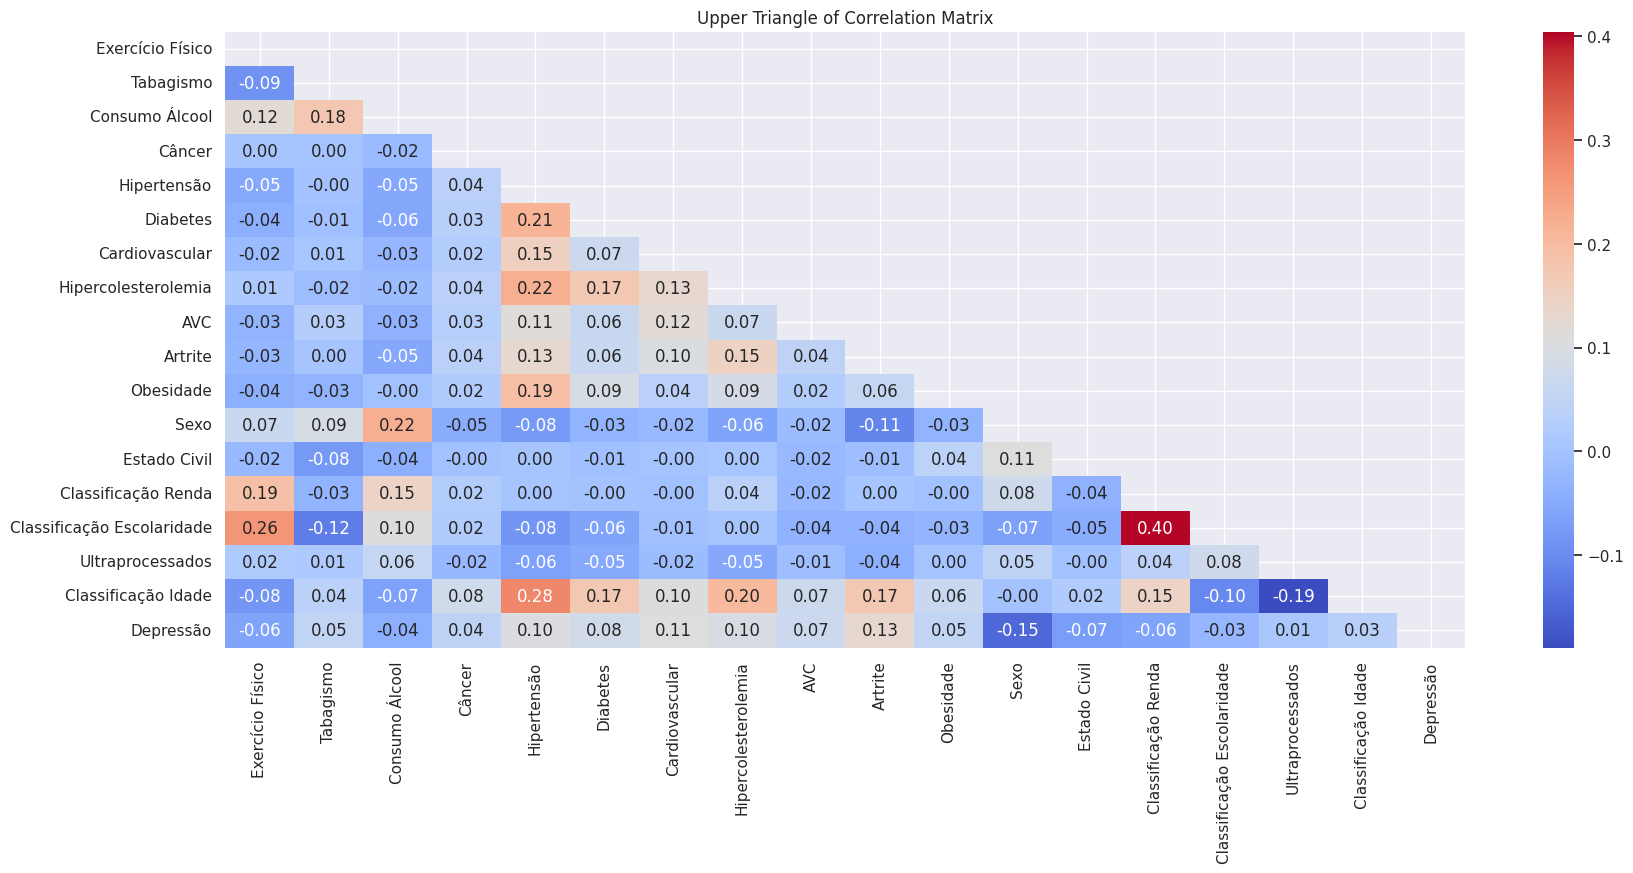

In [58]:
df_total = process_df(df_train_total)
df_total = df_total.rename(columns=variables_names)

df_total = df_total[[col for col in df_total.columns if col != 'Depressão'] + ['Depressão']]
corr_matrix = df_total.corr()
correlations = corr_matrix['Depressão'].abs().sort_values(ascending=False)

mask = np.triu(np.ones(corr_matrix.shape)).astype(bool)
fig, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", ax=ax)
ax.set_title("Upper Triangle of Correlation Matrix")
fig.savefig(PATH_GEN_DATA / 'personr_matrix.png')
plt.show()

In [54]:
from scipy import stats

data = []
for c in df_total.columns: 
    corr, p_value = stats.pearsonr(df_total[c], df_total['Depressão'])
    data.append([c, corr, p_value])

df = pd.DataFrame(data, columns=['var', 'r', 'p'])

df.to_excel(PATH_GEN_DATA / 'pearson_r.xlsx')
df

In [31]:
correlations.head(30)

depression             1.000000
sexo                   0.151905
artrite                0.130409
cardiovascular         0.107613
hipertensao            0.102234
hipercolesterolemia    0.098234
diabetes               0.080024
estado_civil           0.072990
avc                    0.068793
exerc_fisico           0.059380
class_renda            0.059227
tabagismo              0.052019
obesidade              0.049887
cancer                 0.043146
cons_alcool            0.038470
class_idade            0.033487
escolaridade           0.025452
upf                    0.008848
Name: depression, dtype: float64

#### Exluindo todos dados nulos

In [16]:
df_total = process_df(df_train_total)

X = df_total.drop('depression', axis=1)
y = df_total['depression']

model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

model, df_metrics = run_model_dep_classification(model, X, y)
df_importances = create_df_importances(X.columns, model.coef_[0], model.intercept_[0])

display(df_metrics)
display(df_importances)

df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, 'log_all_dropna')
df_importances_all = append_df_importances(df_importances_all, df_importances, 'log_all_dropna')

#### Usando a media/mediana

In [17]:
df_total = process_df(df_train_total, remove_na=False)

X = df_total.drop('depression', axis=1)
y = df_total['depression']

model = Pipeline([
    ('imp', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('reg', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

model, df_metrics = run_model_dep_classification(model, X, y)
df_importances = create_df_importances(X.columns, model.named_steps['reg'].coef_[0],  model.named_steps['reg'].intercept_[0])

display(df_metrics)
display(df_importances)

df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, 'log_all_meanimp')
df_importances_all = append_df_importances(df_importances_all, df_importances, 'log_all_meanimp')

In [18]:
df_total = process_df(df_train_total, remove_na=False)

X = df_total.drop('depression', axis=1)
y = df_total['depression']

model = Pipeline([
    ('imp', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('reg', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

model, df_metrics = run_model_dep_classification(model, X, y)
df_importances = create_df_importances(X.columns, model.named_steps['reg'].coef_[0],  model.named_steps['reg'].intercept_[0])

display(df_metrics)
display(df_importances)

df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, 'log_all_medianimp')
df_importances_all = append_df_importances(df_importances_all, df_importances, 'log_all_medianimp')

### Testando SMOTE

In [19]:

# o SMOTE é uma possibilidade para podermos realizar data augmentation dos dados de pessoas consideradas depressivas
# O desbalanceio das classes é ENORME (~59k não depressivos e 7k depressivos)
# Ele olha a classe com menos quantidade de amostras e gera uma nova distribuição de acordo com as semelhanças entre vizinhos

df_total = process_df(df_train_total)

X = df_total.drop('depression', axis=1)
y = df_total['depression']

model = Pipeline([
    ('smt', SMOTE(sampling_strategy='auto', random_state=42)),
    ('reg', LogisticRegression(max_iter=1000, class_weight=None, random_state=42))
])

model, df_metrics = run_model_dep_classification(model, X, y)
df_importances = create_df_importances(X.columns, model.named_steps['reg'].coef_[0],  model.named_steps['reg'].intercept_[0])

display(df_metrics)
display(df_importances)

df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, 'log_all_smote')
df_importances_all = append_df_importances(df_importances_all, df_importances, 'log_all_smote')

### Ajuste Hyper-parametro

In [20]:
df_total =  process_df(df_train_total)

X = df_total.drop('depression', axis=1)
y = df_total['depression']

param_grid = {
    'reg__C': [0.1, 1.0, 10.0],
    'reg__solver': ['liblinear', 'saga'],
    'reg__max_iter': [100, 500, 1000]
}


model = Pipeline([
    ('reg', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X, y)
model_log = grid_search.best_estimator_
print("Best params: ")
print(grid_search.best_params_)

model_log, df_metrics = run_model_dep_classification(model_log, X, y)
df_importances = create_df_importances(X.columns, model_log.named_steps['reg'].coef_[0],  model_log.named_steps['reg'].intercept_[0])

display(df_metrics)
display(df_importances)

df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, 'log_best_grid')
df_importances_all = append_df_importances(df_importances_all, df_importances, 'log_best_grid')

### Variação fatores ao longo do curso da vida e de variaveis sociodemográficas

In [21]:
df_total = process_df(df_train_total)
df_total_raw = copy.deepcopy(df_train_total)

tests = {

    'log_class_renda_baixa': df_total[df_total['class_renda'] == 0.0].drop('class_renda', axis=1),
    'log_class_renda_alta': df_total[df_total['class_renda'] == 1.0].drop('class_renda', axis=1),

    'log_class_sexo_mulher': df_total[df_total['sexo'] == 0].drop('sexo', axis=1),
    'log_class_sexo_homem': df_total[df_total['sexo'] == 1].drop('sexo', axis=1),

    'log_class_idade_less40': df_total[df_total['class_idade'] <= 2].drop('class_idade', axis=1),
    'log_class_idade_more40': df_total[df_total['class_idade'] > 2].drop('class_idade', axis=1),

    'log_class_idade1': df_total[df_total['class_idade'] == 1].drop('class_idade', axis=1),
    'log_class_idade2': df_total[df_total['class_idade'] == 2].drop('class_idade', axis=1),
    'log_class_idade3': df_total[df_total['class_idade'] == 3].drop('class_idade', axis=1),
    'log_class_idade4': df_total[df_total['class_idade'] == 4].drop('class_idade', axis=1),


    'log_class_r_norte': process_df(df_total_raw[df_total_raw['r_norte'] == 1]),
    'log_class_r_nordeste': process_df(df_total_raw[df_total_raw['r_nordeste'] == 1]),
    'log_class_r_sudeste': process_df(df_total_raw[df_total_raw['r_sudeste'] == 1]),
    'log_class_r_sul': process_df(df_total_raw[df_total_raw['r_sul'] == 1]),
    'log_class_r_centro_oeste': process_df(df_total_raw[df_total_raw['r_centro_oeste'] == 1]),

}
for key, df_selected in tests.items():
    X = df_selected.drop('depression', axis=1)
    y = df_selected['depression']

    model = Pipeline([
        ('reg', LogisticRegression(max_iter=100, class_weight='balanced', solver='liblinear', C=10, random_state=42))
    ])

    model, df_metrics = run_model_dep_classification(model, X, y)
    df_importances = create_df_importances(X.columns, model.named_steps['reg'].coef_[0],  model.named_steps['reg'].intercept_[0])

    df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, key)
    df_importances_all = append_df_importances(df_importances_all, df_importances, key)

    print("{}: {}, f1: {}".format(key, len(df_selected)/ len(df_total), df_metrics['test_f1'][0]))


## Arvore de Decisão

In [22]:
df_total = process_df(df_train_total)

X = df_total.drop('depression', axis=1)
y = df_total['depression']

param_grid = {
    'class__criterion': ['gini', 'entropy'],
    'class__max_depth': [None, 5, 10],
    'class__min_samples_split': np.arange(0, 0.05, 0.01),
    'class__min_samples_leaf': np.arange(0.01, 0.05, 0.01)
}


model = Pipeline([
    ('class', DecisionTreeClassifier(class_weight='balanced', random_state=43, min_samples_split=0.05, min_samples_leaf=0.01))
])

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X, y)
model_dt = grid_search.best_estimator_
print("Best params: ")
print(grid_search.best_params_)

model_dt, df_metrics = run_model_dep_classification(model_dt, X, y)
df_importances = create_df_importances(X.columns, model_dt.named_steps['class'].feature_importances_,  None)

display(df_metrics)
display(df_importances)

df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, 'dt_exp')
df_importances_all = append_df_importances(df_importances_all, df_importances, 'dt_exp')

In [23]:
dot_data = tree.export_graphviz(model_dt.named_steps['class'], out_file=None,
                                feature_names=X.columns,
                                class_names=['False', 'True'],
                                filled=True, proportion=True)
# Draw graph
graph = pydot.graph_from_dot_data(dot_data)[0]
graph.write_svg(PATH_GEN_DATA/"decistion_tree.svg")

In [24]:
model = copy.deepcopy(model_dt)
prune_duplicate_leaves(model.named_steps['class'])

dot_data = tree.export_graphviz(model.named_steps['class'], out_file=None,
                                feature_names=X.columns,
                                class_names=['False', 'True'],
                                filled=True, proportion=True)
# Draw graph
graph = pydot.graph_from_dot_data(dot_data)[0]
graph.write_svg(PATH_GEN_DATA/"decistion_tree_p.svg")

In [25]:
df_total = process_df(df_train_total)

X = df_total.drop('depression', axis=1)
y = df_total['depression']

param_grid = {
    'class__criterion': ['gini', 'entropy'],
    'class__max_depth': [None, 5, 10],
    'class__min_samples_split': np.arange(0, 0.05, 0.01),
    'class__min_samples_leaf': np.arange(0.01, 0.05, 0.01)
}


model = Pipeline([
    ('imp', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('class', RandomForestClassifier(class_weight='balanced', random_state=43, min_samples_split=0.05, min_samples_leaf=0.01))
])

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X, y)
model_rf = grid_search.best_estimator_
print("Best params: ")
print(grid_search.best_params_)

model_rf, df_metrics = run_model_dep_classification(model_rf, X, y)
df_importances = create_df_importances(X.columns, model_rf.named_steps['class'].feature_importances_,  None)

display(df_metrics)
display(df_importances)

df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, 'rf_exp')
df_importances_all = append_df_importances(df_importances_all, df_importances, 'rf_exp')

### Salvando/exibindo tabelas criadas

In [26]:
df_metrics_all.to_excel(PATH_GEN_DATA / 'metrics.xlsx')
df_metrics_all

In [27]:
df_importances_all.to_excel(PATH_GEN_DATA / 'importances.xlsx')
df_importances_all

# Comparando modelos

In [28]:
df_total = process_df(df_train_total)

X = df_total.drop('depression', axis=1)
y = df_total['depression']

df_test =  process_df(df_test_total)
X_test = df_test.drop('depression', axis=1)
y_test = df_test['depression']

modeldict = {'Logistic Regression': model_log, 'Decision Tree': model_dt, 'Random Forest': model_rf}

plot_roc_curve(modeldict, X_test, y_test, path=PATH_GEN_DATA/'roc.png')
plot_cm(model_log, X_test, y_test, path=PATH_GEN_DATA/'cm.png')

metrics_test = classification_metrics(modeldict, X, y, X_test, y_test)
metrics_test.to_excel(PATH_GEN_DATA / 'test_metrics.xlsx')
metrics_test